In [1]:
import os
import warnings
import pandas as pd

from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from stop_words import get_stop_words
import spacy

os.chdir("../")
warnings.filterwarnings("ignore")

from src.modeling import BERTopic_
from src.config import (
    umap_data,
    hdbscan_data,
    sent_transformers_data,
    tfidf_data,
    tokenizer_data,
    mmr_data,
    bertopic_data,
)
from src.data_preprocess import Preprocessing
from src.utils import (
    getClusteringModel,
    getDimReductionModel,
    getMaximalMarginalRelevance,
    getTfidfTransformers,
    getTokenizer,
    getEmbeddings,
    getFrequencyDictForText,
    create_wordcloud,
    global_wordcloud
)

# Custom Model Test

In [14]:
language = "french"
spacy_model = 'fr_core_news_md'
transformer = "dangvantuan/sentence-camembert-base"
preprocessor = Preprocessing(spacy_model)

docs_name = "chatbot-sample"

list_context_sw = ["\?", "question", "pouvoir", "chez", "club", "valider", "vouloir", "offrir", "perdre", "fonctionner", "utiliser", "voir", "ok", "total", "venir", "reformuler", "'", "\.", "recevoir", ","]

sample_file_path =  "./data/chatbot_data_file_sample.csv"
with open(sample_file_path, 'rb') as f:
    df_docs = pd.read_csv(f, sep="|")

In [15]:
docs = df_docs["question"].apply(preprocessor.lemmatizer).tolist()

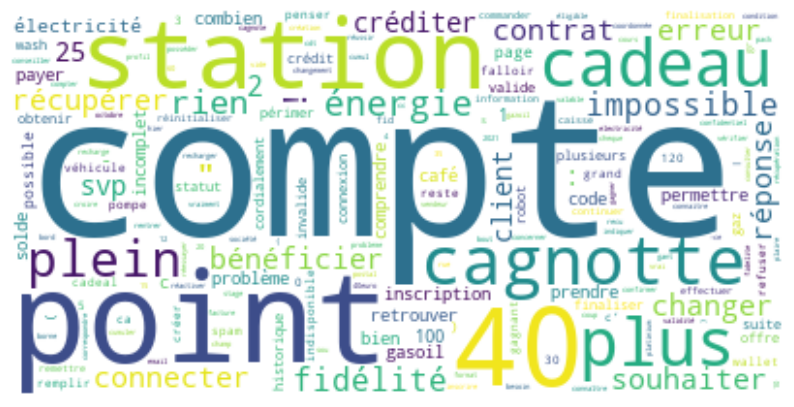

In [16]:
global_wordcloud(" ".join(docs), language, list_context_sw)

In [5]:
# transformer_ = "all-MiniLM-L6-v2"
# docs_name = "fetch-sample"
# language = "english"

# docs = fetch_20newsgroups(
#    subset="all",
#    remove=("headers", "footers", "quotes")
#    )["data"]

In [6]:
umap_model = getDimReductionModel(umap_data())
hdbscan_model = getClusteringModel(hdbscan_data())
vectorizer_model = getTokenizer(tokenizer_data(language=language), list_context_sw)
ctfidf_model = getTfidfTransformers(tfidf_data())
mmr_model = getMaximalMarginalRelevance(mmr_data())

In [7]:
bertopic_config = bertopic_data(
    umap_model, hdbscan_model, vectorizer_model, ctfidf_model, mmr_model,
)

In [8]:
bert_topic_inst = BERTopic_(bertopic_config)

In [9]:
bert_topic_inst.fit_or_load(transformer, docs_name, docs)

In [10]:
bert_topic_inst.visual_inference()

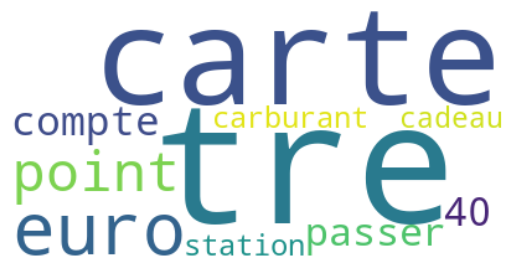

In [11]:
create_wordcloud(bert_topic_inst.model, 0)

In [12]:
bert_topic_inst.tabular_inference(docs)[0]

,Topic,Count,Name
0,0,908,0_tre_carte_euro_point
1,1,35,1_non_pari_clture_xx
2,2,24,2_bob_chat_tl_puer
3,3,19,3____
4,4,14,4_inutile_cagnotte__


In [13]:
bert_topic_inst.model.get_topic(3)

[('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05)]